In [1]:
import yaml
import joblib
import argparse
import numpy as np
from tqdm import tqdm
from datetime import datetime
from data.fakeforensics import load_fakeforensics_data

from ppg.ppg_c import PPG_C
from ppg.ppg_g import PPG_G
from utils.roi import ROIProcessor, DetectionError
from utils.logging import setup_logging
from ppg.interpolate import frequency_resample
from feature.feature_extractor import FeatureExtractor




In [38]:

def segment_ppg(video_path, config):
    """Process a single video to extract features."""
    try: 
        landmarker = ROIProcessor(video_path, config)
    except DetectionError:
        return None, None
    # annotated_frames, fps = landmarker.detect_with_draw()
    # output_video_path = "output_video.mp4"
    # save_annotated_video(annotated_frames, fps, output_video_path)
    R_means_array, L_means_array, M_means_array, original_fps = landmarker.detect_with_calculate()
    if R_means_array.shape[0] == 0:
        return None, None

    time_interval = config['seg_time_interval']
    target_fps = config['fps_standard']
    ppgs = []
    for i in range(R_means_array.shape[0]):
        G_R = PPG_G(R_means_array[i], original_fps).compute_signal()
        G_L = PPG_G(L_means_array[i], original_fps).compute_signal()
        G_M = PPG_G(M_means_array[i], original_fps).compute_signal()
        C_R = PPG_C(R_means_array[i], original_fps).compute_signal()
        C_L = PPG_C(L_means_array[i], original_fps).compute_signal()
        C_M = PPG_C(M_means_array[i], original_fps).compute_signal()
        # Segment signals
        R_ROI_G_segments = frequency_resample(G_R, time_interval, original_fps, target_fps)
        R_ROI_C_segments = frequency_resample(C_R, time_interval, original_fps, target_fps)
        L_ROI_G_segments = frequency_resample(G_L, time_interval, original_fps, target_fps)
        L_ROI_C_segments = frequency_resample(C_L, time_interval, original_fps, target_fps)
        M_ROI_G_segments = frequency_resample(G_M, time_interval, original_fps, target_fps)
        M_ROI_C_segments = frequency_resample(C_M, time_interval, original_fps, target_fps)

        # Combine segments
        ppg = [
                L_ROI_G_segments, M_ROI_G_segments, R_ROI_G_segments,
                L_ROI_C_segments, M_ROI_C_segments, R_ROI_C_segments
            ]
        ppgs.append(ppg)

    return ppgs



In [40]:

import matplotlib.pyplot as plt

def visualize_segments(ppg, label, x_label, y_label, title="PPG Segments Visualization"):
    """
    Visualize each segment in the PPG data.
    
    Args:
        ppg (list of np.ndarray): List of PPG signal segments.
        labels (list of str, optional): Labels for each segment.
        title (str): Title of the plot.
    """
    
    plt.plot(ppg, label=label)  # Flatten in case it's multi-dimensional

    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()


In [103]:
# Extract features
config_path = "/root/github/25th-conference-fakebusters/model/fakecatcher/utils/config.yaml"
# Load configuration
with open(config_path, 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)
video_path = '/root/github/25th-conference-fakebusters/model/fakecatcher/uploaded_videos/trump_real.mp4'

In [104]:
real_ppgs = segment_ppg(video_path, config)

I0000 00:00:1735482600.694521  314536 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1735482600.695053  314536 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1735482600.707932  338286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1735482600.733635  338303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing Frames: 100%|██████████| 171/171 [00:00<00:00, 231.98frame/s]


In [46]:
len(real_ppgs)

2

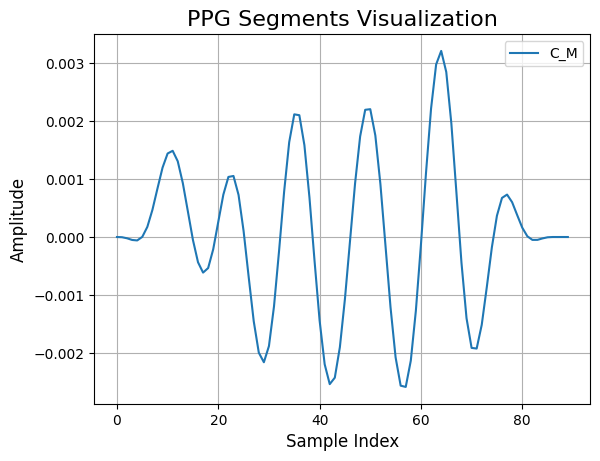

In [47]:
visualize_two_segments(real_ppgs[0][4], fake_ppg=fake_ppgs[0][4] label="C_M", x_label="Frames", y_label="C PPG")

In [105]:
# Extract features
config_path = "/root/github/25th-conference-fakebusters/model/fakecatcher/utils/config.yaml"
# Load configuration
with open(config_path, 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)
video_path = '/root/github/25th-conference-fakebusters/model/fakecatcher/uploaded_videos/trump_fake.mp4'
fake_ppgs = segment_ppg(video_path, config)
fake_ppgs

I0000 00:00:1735482625.421550  314536 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1735482625.422111  314536 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1735482625.433454  338447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1735482625.460642  338471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing Frames: 100%|██████████| 336/336 [00:01<00:00, 189.68frame/s]


[[array([ 0.00000000e+00, -6.15312480e-04, -4.72406564e-03, -1.54784307e-02,
         -3.01235359e-02, -3.61613985e-02, -1.34673003e-02,  5.61708688e-02,
          1.77170353e-01,  3.32580287e-01,  4.85017454e-01,  5.84874320e-01,
          5.82323136e-01,  4.40862919e-01,  1.52241448e-01, -2.48990725e-01,
         -6.79715030e-01, -1.02267774e+00, -1.16651142e+00, -1.05725897e+00,
         -7.36616087e-01, -3.34907633e-01, -9.07116623e-03,  1.26819094e-01,
          4.81533167e-02, -1.67928188e-01, -3.86253695e-01, -4.83605090e-01,
         -4.07135730e-01, -1.92065614e-01,  7.60214645e-02,  3.14899543e-01,
          4.87125631e-01,  6.02639167e-01,  6.84299674e-01,  7.40124771e-01,
          7.52172551e-01,  6.99976552e-01,  5.92650072e-01,  4.70662466e-01,
          3.90039552e-01,  3.74987116e-01,  3.91905478e-01,  3.66005592e-01,
          2.01709664e-01, -1.49060917e-01, -6.40784252e-01, -1.14984113e+00,
         -1.49370247e+00, -1.52421167e+00, -1.22653401e+00, -7.13325565e-01,

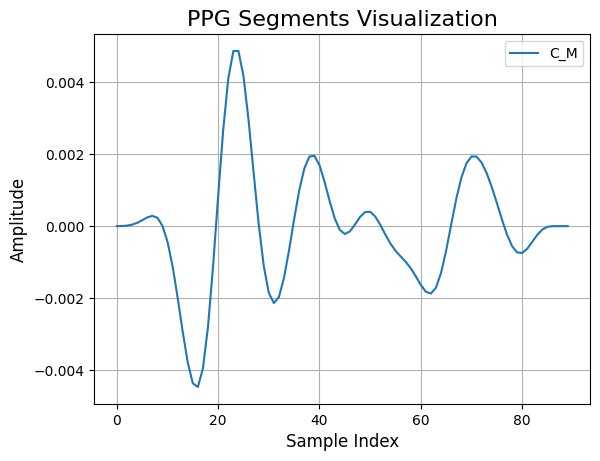

In [49]:
visualize_two_segments(fake_ppgs=fake_ppgs[0][4], real_ppgs=real_ppgs[0][4], label="C_M")

In [91]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def visualize_two_segments(fake_ppg, real_ppg, x_values=None, x_labels = 'X-axis Label',y_labels = 'Amplitude', title="Comparison of PPG Segments", label="C_M"):
    """
    Visualize two PPG segments (fake and real) on the same plot with custom x-axis values.
    
    Args:
        fake_ppg (np.ndarray): The fake PPG signal to visualize.
        real_ppg (np.ndarray): The real PPG signal to visualize.
        x_values (np.ndarray or list, optional): Custom x-axis values.
        title (str): Title of the plot.
        label (str): Label for the segments.
    """
    plt.figure(figsize=(12, 6))
    
    # Set x values
    if x_values is None:
        x_values = range(len(fake_ppg))  # Default to indices if no x_values are provided
    
    # Plot fake PPG
    plt.plot(x_values, fake_ppg.flatten(), label=f"Fake {label}", linestyle="--", color="teal")
    
    # Plot real PPG
    plt.plot(x_values, real_ppg.flatten(), label=f"Real {label}", linestyle="-", color="orange")
    
    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(x_labels, fontsize=12)
    plt.ylabel(y_labels, fontsize=12)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()


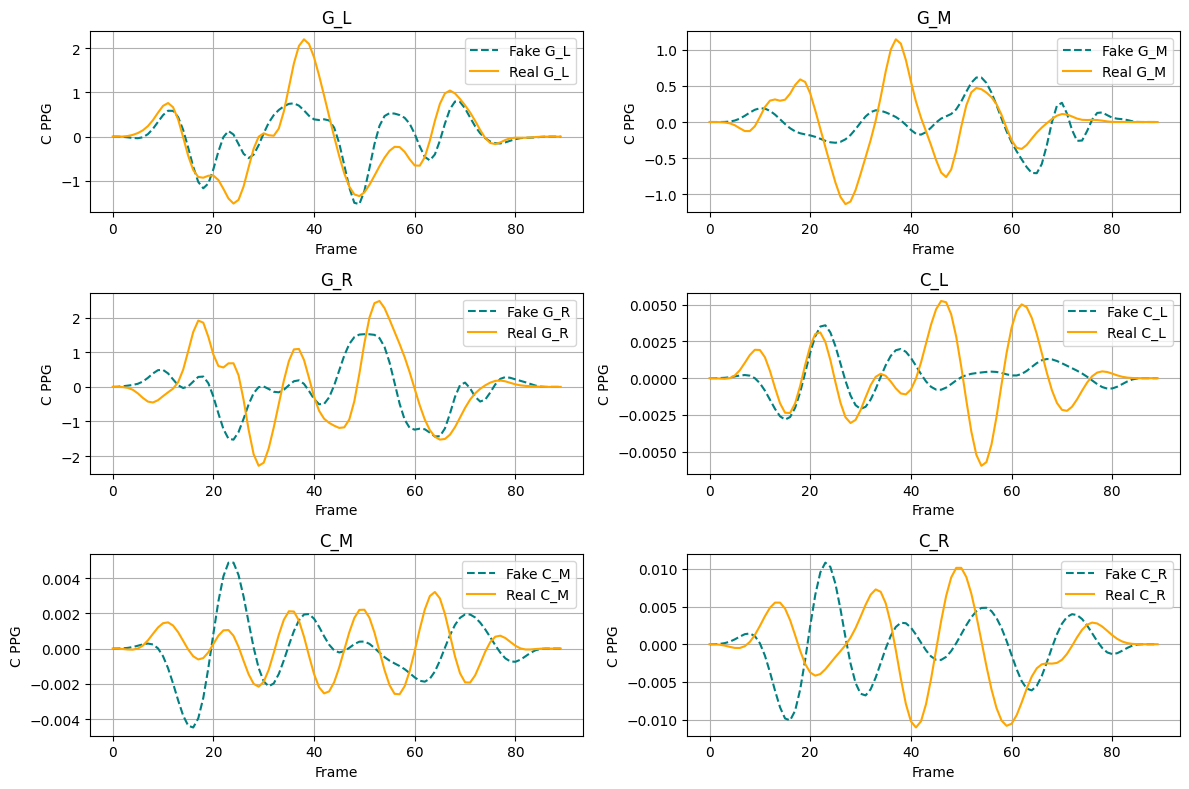

In [106]:
import matplotlib.pyplot as plt

def visualize_multiple_segments(fake_ppgs, real_ppgs, labels, x_label="Frame", y_label="C PPG"):
    """
    Visualize multiple PPG segments in a grid layout.

    Args:
        fake_ppgs (list of np.ndarray): List of fake PPG signals.
        real_ppgs (list of np.ndarray): List of real PPG signals.
        labels (list of str): Labels for each segment.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
    """
    num_segments = len(labels)
    cols = 2  # Number of columns
    rows = (num_segments + cols - 1) // cols  # Calculate required rows

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for i in range(num_segments):
        ax = axes[i]
        ax.plot(fake_ppgs[0][i].flatten(), label=f"Fake {labels[i]}", linestyle="--", color="teal")
        ax.plot(real_ppgs[0][i].flatten(), label=f"Real {labels[i]}", linestyle="-", color="orange")
        ax.set_title(labels[i], fontsize=12)
        ax.set_xlabel(x_label, fontsize=10)
        ax.set_ylabel(y_label, fontsize=10)
        ax.legend(loc="upper right")
        ax.grid(True)

    # Remove any unused subplots
    for i in range(num_segments, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


labels = ['G_L', 'G_M', 'G_R', 'C_L', 'C_M', 'C_R']
visualize_multiple_segments(fake_ppgs, real_ppgs, labels)


In [67]:
from feature.signal_transformation import *
log_fake_ppg = log(np.array(fake_ppgs))[0]
freq, fake_psd = pairwise_cross_spectral_density(log_fake_ppg[4], log_fake_ppg[4])
fake_psd

array([1.02911239e-24, 7.60703354e-24, 1.92792722e-23, 7.14748904e-24,
       3.93787326e-23, 2.10240358e-23, 7.24741856e-23, 2.17993587e-23,
       9.10289394e-24, 2.08355255e-25, 7.80743043e-25, 1.58731602e-25,
       4.00934139e-27, 1.21843955e-27, 3.26664337e-28, 8.11001428e-30,
       2.23557845e-29, 4.06871916e-29, 5.33625590e-29, 9.44005323e-30,
       1.24117502e-29, 1.17198360e-29, 1.16513287e-29, 4.83078683e-30,
       3.13947813e-30, 7.53870973e-30, 7.65721284e-32, 1.46173806e-29,
       7.99125896e-30, 3.46576431e-31, 1.20356980e-30, 1.14831673e-30,
       1.32270987e-30, 7.63197911e-31, 1.33610787e-30, 3.70811694e-30,
       3.70529882e-30, 3.21197863e-30, 3.53978620e-31, 1.78640529e-31,
       8.03087717e-31, 1.69616917e-31, 2.04710257e-31, 1.96892388e-30,
       1.87776849e-30, 3.73575046e-31])

In [60]:
import matplotlib.pyplot as plt

def visualize_psd(freq, psd, title="Power Spectral Density (PSD)", label="PSD"):
    """
    Visualize the power spectral density (PSD).
    
    Args:
        freq (np.ndarray): Frequencies corresponding to the PSD.
        psd (np.ndarray): Power spectral density values.
        title (str): Title of the plot.
        label (str): Label for the PSD line.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(freq, psd, label=label, color="blue")
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Power Spectral Density", fontsize=12)
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
log(real_ppgs)

/root/miniconda3/envs/video/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 90, using nperseg = 90
  warnings.warn('nperseg = {0:d} is greater than input length '


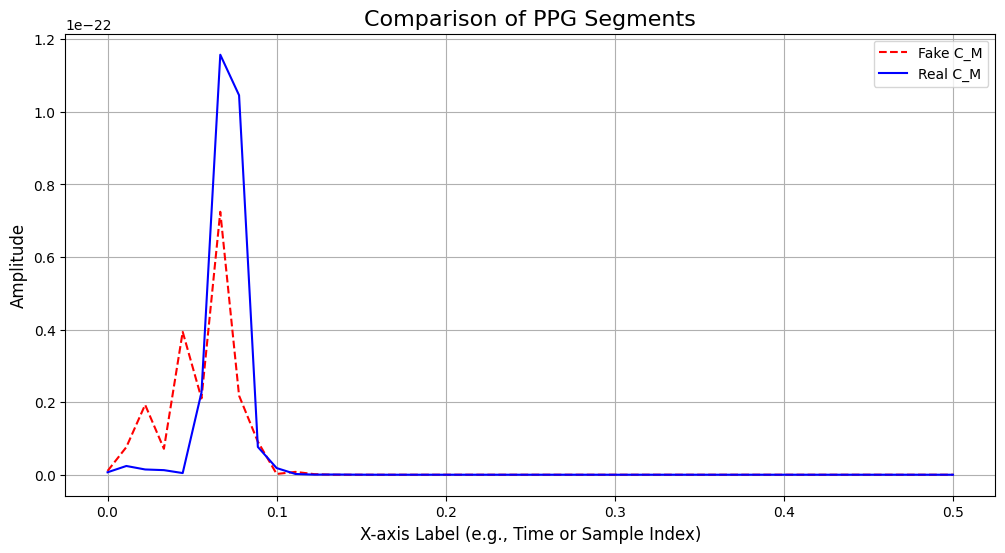

In [ ]:
from feature.signal_transformation import *
log_real_ppg = log(np.array(real_ppgs))[0]
real_freq, real_psd = pairwise_cross_spectral_density(log_real_ppg[4], log_real_ppg[4])

visualize_two_segments(fake_pp=fake_psd, real_ppg=real_psd, x_values=real_freq, y_labels='dB', title="CPSD")

In [78]:
def compute_non_negative_correlation(signal1, signal2, normalize=True):
    """
    Compute the non-negative correlation between two signals.

    Args:
        signal1 (np.ndarray): First signal.
        signal2 (np.ndarray): Second signal.
        normalize (bool): Whether to normalize the correlation values (0 to 1).
    
    Returns:
        correlation (np.ndarray): Non-negative correlation values.
    """
    # Ensure signals are the same length
    if len(signal1) != len(signal2):
        raise ValueError("Signals must have the same length.")

    # Compute raw correlation
    correlation = np.correlate(signal1, signal2, mode='full')
    
    # Make correlation non-negative by applying absolute value or squaring
    correlation = np.abs(correlation)  # Use np.square(correlation) if needed

    # Normalize correlation (0 to 1 range)
    if normalize:
        correlation = correlation / np.max(correlation)

    return correlation

In [107]:
fake_correlation_C_M_O = compute_non_negative_correlation(fake_ppgs[0][3], fake_ppgs[0][4])

In [108]:
real_correlation_C_M_O = compute_non_negative_correlation(real_ppgs[0][3], real_ppgs[0][4])

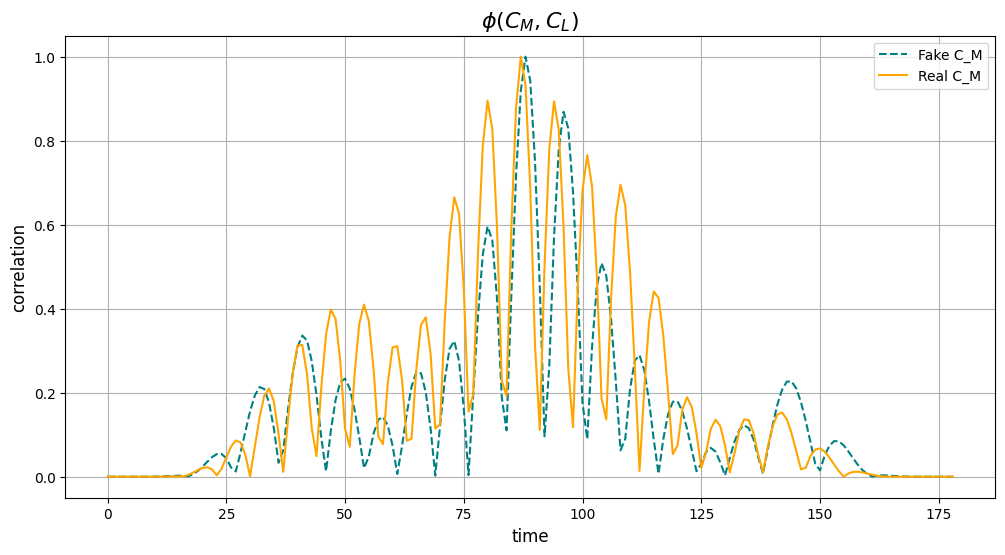

In [109]:
visualize_two_segments(fake_correlation_C_M_O, real_correlation_C_M_O,x_labels='time', y_labels='correlation', title="$\phi(C_M, C_L)$")

In [110]:
freq, CPSD_C_O = pairwise_cross_spectral_density(log(real_ppgs[0][3]), log(real_ppgs[0][4]))
freq, CPSD_C_S = pairwise_cross_spectral_density(log(fake_ppgs[0][3]), log(fake_ppgs[0][4]))

/root/miniconda3/envs/video/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 90, using nperseg = 90
  warnings.warn('nperseg = {0:d} is greater than input length '


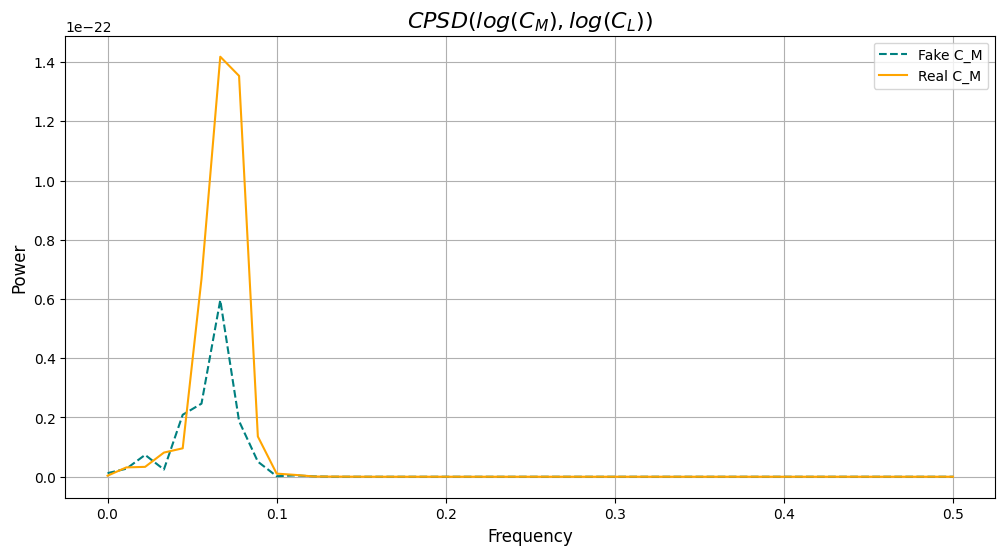

In [111]:
visualize_two_segments(CPSD_C_S, CPSD_C_O,freq,"Frequency","Power", "$CPSD(log(C_M), log(C_L))$")

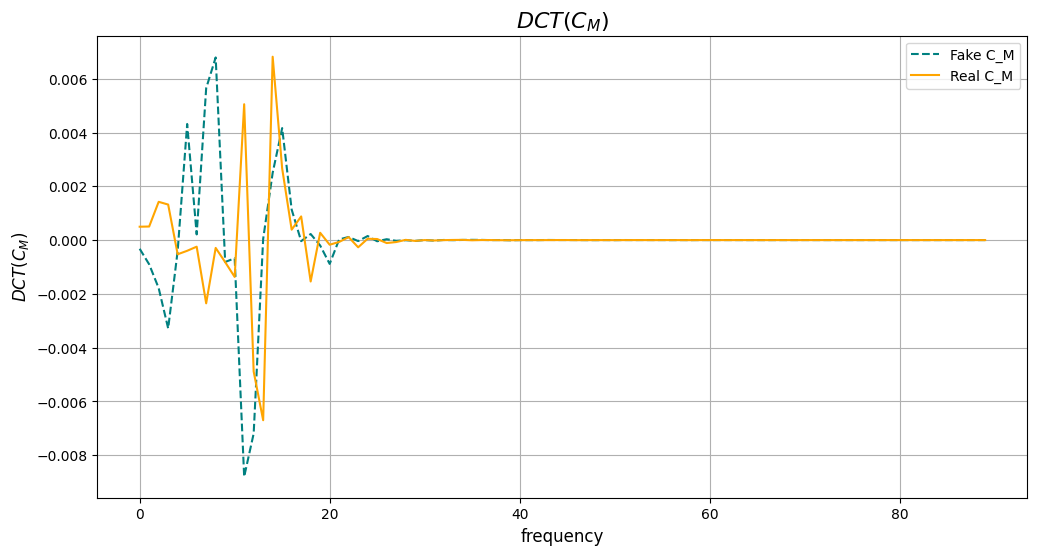

In [112]:
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# DCT-II 변환
fake_dct_signal = dct(fake_ppgs[0][4], type=2, norm='ortho')

real_dct_signal = dct(real_ppgs[0][4], type=2, norm='ortho')
visualize_two_segments(fake_ppg=fake_dct_signal, real_ppg=real_dct_signal,x_labels="frequency", y_labels="$DCT(C_M)$", title="$DCT(C_M)$")


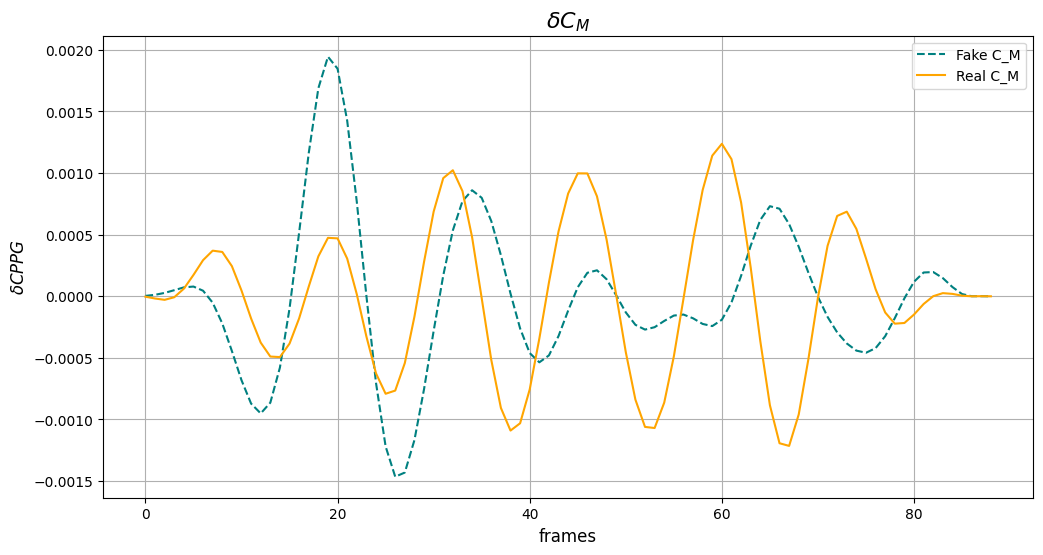

In [123]:
# real
real_derivative = np.diff(real_ppgs[0][4]) 

# fake
dx = fake_ppgs[0][1] - fake_ppgs[0][0]  # Sampling interval
fake_derivative = np.diff(fake_ppgs[0][4]) 

visualize_two_segments(fake_ppg=fake_derivative, real_ppg=real_derivative,x_labels="frames", y_labels="$\delta CPPG$", title="$\delta C_M$")


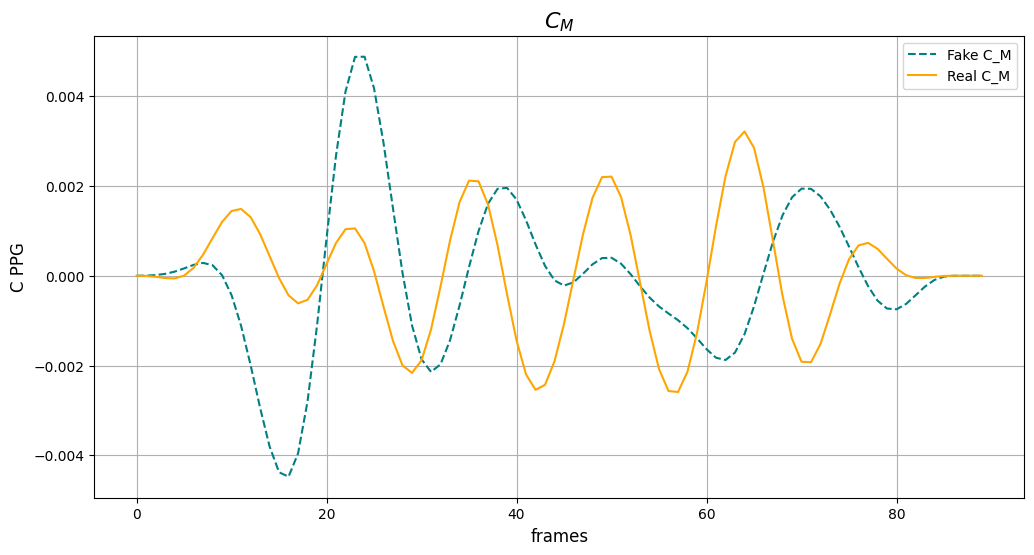

In [124]:
visualize_two_segments(fake_ppg=fake_ppgs[0][4], real_ppg=real_ppgs[0][4], x_labels="frames", y_labels="C PPG", title="$C_M$")

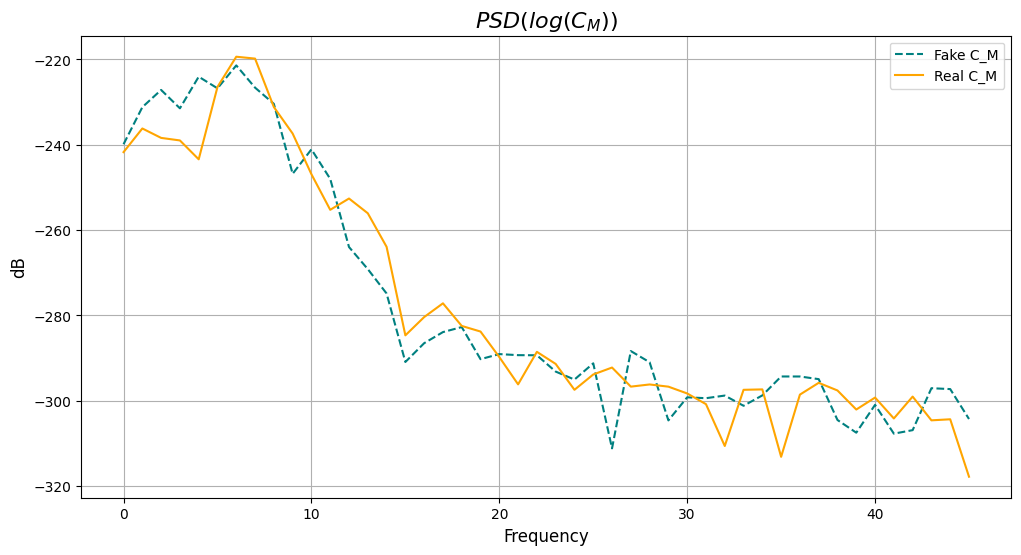

In [128]:
from scipy.signal import welch

frequencies, fake_psd = welch(log(fake_ppgs[0][4]))
fake_psd_db = 10 * np.log10(fake_psd)

freq, real_psd = welch(log(real_ppgs[0][4]))
real_psd_db = 10 * np.log10(real_psd)
visualize_two_segments(fake_ppg=fake_psd_db, real_ppg=real_psd_db, x_labels="Frequency", y_labels="dB", title='$PSD(log(C_M))$')


In [24]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_rows(matrix, title="Row-wise Visualization"):
    """
    Visualize each row of a NumPy matrix as a line plot.
    
    Args:
        matrix (np.ndarray): The input NumPy matrix to visualize.
        title (str): Title of the plot.
    """
    if not isinstance(matrix, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    
    num_rows, num_cols = matrix.shape
    plt.figure(figsize=(12, 8))

    plt.plot(matrix[0], label=f'Row {0+1}')

    plt.title(title, fontsize=16)
    plt.xlabel("Column Index", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()


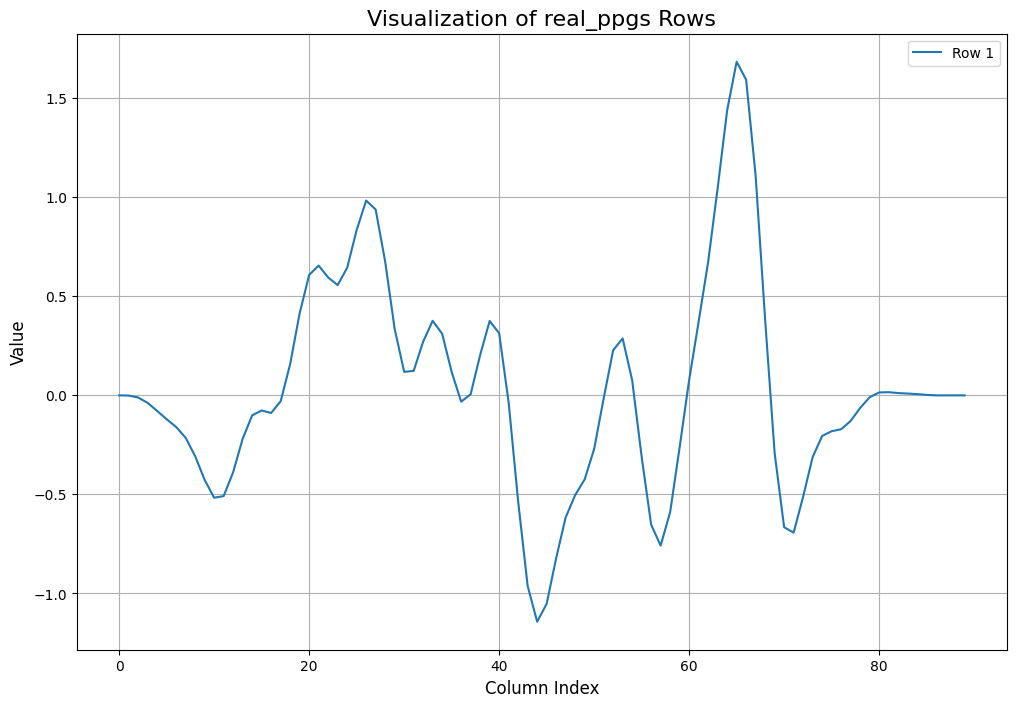

In [25]:
# Example usage
visualize_rows(real_ppgs, title="Visualization of real_ppgs Rows")

In [27]:
fake_ppgs = np.array(fake_ppgs)

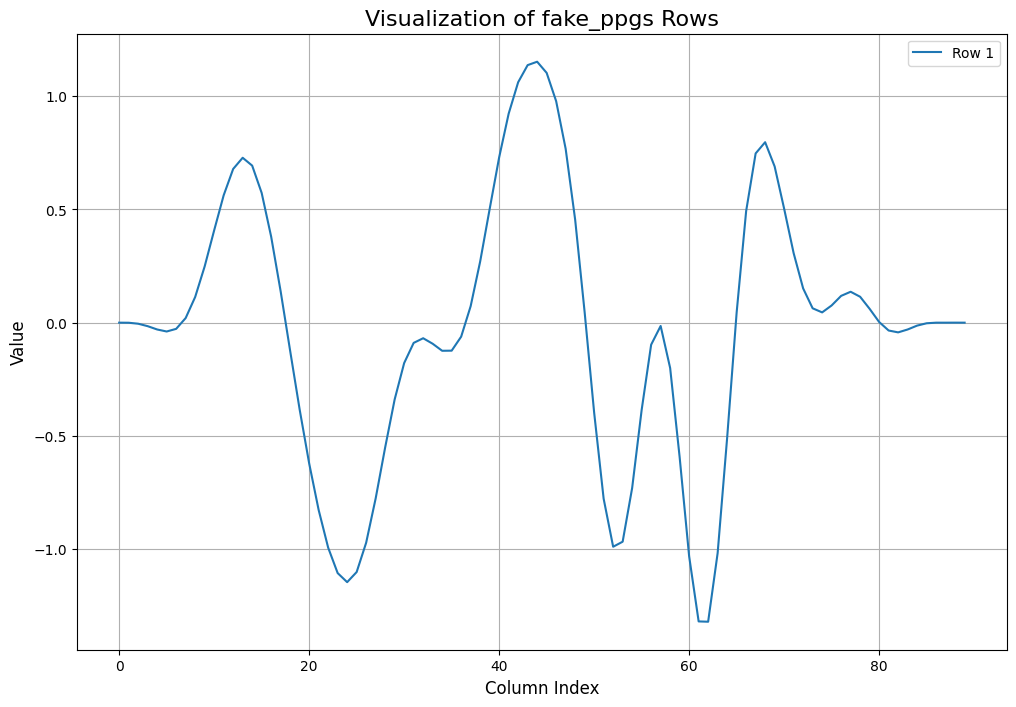

In [28]:
# Example usage
visualize_rows(fake_ppgs, title="Visualization of fake_ppgs Rows")

In [ ]:

def main():

    # parser = argparse.ArgumentParser()
    # parser.add_argument('-c', '--config_path', type=str, required=True, help="Path to the config file.")
    # args = parser.parse_args()
    
    
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    feature_save_path = f"features_{current_time}.pkl"
    
    # Load data
    video_paths, true_labels = load_fakeforensics_data(config["meta_data_csv_path"])
    logger.info(f"Loaded {len(video_paths)} videos.")

    # Extract features
    video_features, video_labels = [], []
    for video_path, true_label in tqdm(zip(video_paths, true_labels), desc='Processing videos'):

        features = extract_feature(video_path, config)
        if isinstance(features, np.ndarray):
            video_features.append(features)
            video_labels.append(true_label)
            # feature 저장
        joblib.dump({'features': video_features, 'labels': video_labels}, feature_save_path)
    
    # feature 저장
    joblib.dump({'features': video_features, 'labels': video_labels}, feature_save_path)
    logger.info(f"Extracted features saved to {feature_save_path}.")

if __name__ == "__main__":
    main()


ImportError: attempted relative import with no known parent package